# Project 3.1.1 Data Cleaning and Data Science Process
---
Following scraping textual information from reddit posts, we now continue with the data science process of data cleaning, EDA, model building, evaluation and lastly recommendation of business solutions.

In [350]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# always be stylish
plt.style.use('ggplot')

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
# Read in google home reddit data
df_gh = pd.read_csv('./reddit_gh.csv')
df_gh.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,media,is_video,link_flair_template_id,post_hint,preview,media_metadata,crosspost_parent_list,crosspost_parent,author_cakeday,poll_data
0,NaN,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,t2_q648wkk,False,NaN,0,False,FAQ: Please read the subreddit FAQ before post...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,googlehome,Do you want to liberate your Google so it can ...,t2_8hlsb,False,NaN,0,False,My Google has Coronavirus! - Monthly Rants and...,[],...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,googlehome,Because that's all it is.,t2_1mgxh,False,NaN,0,False,[Subreddit Request] Can we rename this subredd...,[],...,NaN,False,489ab03e-b78e-11e6-8fd6-0e00dc2f4472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,googlehome,NaN,t2_mnm0w,False,NaN,0,False,This one really takes the cake.,[],...,NaN,False,NaN,image,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,googlehome,NaN,t2_me5yarn,False,NaN,0,False,Where did my routines go to? They're still in ...,[],...,NaN,False,0ab35abe-b78e-11e6-9303-0ed3c72a1f42,image,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN


The columns with the more relevant textual data are from subreddit, selftext and title. 

In [3]:
# Set a new dataframe with the columns we want ()
df_gh1 = pd.DataFrame(df_gh[['subreddit', 'selftext', 'title']])
# Shape of dataframe
df_gh1.shape

(996, 3)

In [4]:
# Drop duplicates in selftext column
df_gh1.drop_duplicates(subset='selftext',inplace=True)
# Shape of dataframe after removing duplicates
df_gh1.shape

(825, 3)

In [5]:
# Drop NAs.
df_gh1.dropna(inplace=True)
# Shape of dataframe after removing NAs
df_gh1.shape

(824, 3)

In [6]:
# Review first 5 rows of dataframe
df_gh1.head()

,subreddit,selftext,title
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...
2,googlehome,Because that's all it is.,[Subreddit Request] Can we rename this subredd...
6,googlehome,So I set an alarm there and Google responded '...,Google just said no problem
7,googlehome,Recently got a Nest WiFi router. I currently l...,Nest WiFi - who can access router settings?


In [7]:
# Read in google pixel reddit data
df_gp = pd.read_csv('./reddit_gp.csv')
df_gp.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,event_start,post_hint,preview,event_end,event_is_live,link_flair_template_id,media_metadata,poll_data,crosspost_parent_list,crosspost_parent
0,NaN,GooglePixel,This is the weekly photo megathread. Photos ca...,t2_6l4z3,False,NaN,0,False,Weekly #madebygoogle Photos Megathread - May 0...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,GooglePixel,*If you were redirected here from a removed po...,t2_zmjf4,False,NaN,0,False,"The May 2020 Superthread: Pixel 4a, Battery, ""...",[],...,1.588345e+09,self,{'images': [{'source': {'url': 'https://extern...,1.588360e+09,False,NaN,NaN,NaN,NaN,NaN
2,NaN,GooglePixel,It was supposed to take up to 10 days. But it ...,t2_10j65hn2,False,NaN,0,False,"So I had some troubles with my phone, and sent...","[{'e': 'text', 't': 'Pixel 3a'}]",...,NaN,NaN,NaN,NaN,NaN,bd247e74-7476-11e9-b802-0e2121dcd2a2,NaN,NaN,NaN,NaN
3,NaN,GooglePixel,Yall weren't kidding about the battery. It's p...,t2_zfetx,False,NaN,0,False,Had my pixel 4 for a few days already and holy...,"[{'e': 'text', 't': 'Pixel 4'}]",...,NaN,NaN,NaN,NaN,NaN,8697ce76-f2dc-11e9-8412-0eae23347634,NaN,NaN,NaN,NaN
4,NaN,GooglePixel,NaN,t2_bkfyp,False,NaN,0,False,Pixel 3a black screen after overnight charging,"[{'e': 'text', 't': 'Pixel 3a'}]",...,NaN,hosted:video,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,bd247e74-7476-11e9-b802-0e2121dcd2a2,NaN,NaN,NaN,NaN


In [8]:
# Set a new dataframe with the columns we want ()
df_gp1 = pd.DataFrame(df_gp[['subreddit', 'selftext', 'title']])
# Shape of dataframe
df_gp1.shape

(980, 3)

In [9]:
# Drop duplicates in selftext column
df_gp1.drop_duplicates(subset='selftext',inplace=True)
# Shape of dataframe after removing duplicates
df_gp1.shape

(803, 3)

In [10]:
# Drop NAs.
df_gp1.dropna(inplace=True)
# Shape of dataframe after removing NAs
df_gp1.shape

(802, 3)

In [11]:
# Join the two dataframes together
df = pd.concat([df_gh1,df_gp1])
df.reset_index(drop=True, inplace=True)
# Shape of concatenated dataframe 
df.shape

(1626, 3)

In [12]:
df['subreddit'].value_counts()

googlehome     824
GooglePixel    802
Name: subreddit, dtype: int64

In [13]:
# Engineer a feature to turn subreddit into a 1/0 column, where 1 indicates googlehome.
df['googlehome'] = df['subreddit'].map({'googlehome': 1, 'GooglePixel': 0})
df.head(2)

,subreddit,selftext,title,googlehome
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,1
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,1


In [14]:
df['googlehome'].value_counts(normalize=True)

1    0.506765
0    0.493235
Name: googlehome, dtype: float64

The distribution of the classes is quite balanced. If the class is imblanced, the resulting model is likely to have low predictive accuracy for the infrequent class.

### Basic EDA
---
Building good performing classifers from data with easily separable classes is relatively straightforward but care should be excercised to determine if such data is representative of the actual world environment. In most real world environment, samples from different classes share similar characteristics or are overlapped. This means the boundaries of each class may not be clearly defined as desired. 

Common practices to address this problem includes:
- i) modifying the original data by introducing/removing features which decrease the overlapping region,
- ii) adapting algorithms to reduce the negative impact of overlapping features.

Through the basic EDA process, we set out to discover what are the prevalent key words among the reddit posts, and their distribution across text data of googlehome and googlepixel reddit posts. With these insights we would then be in better position to fine-tune the subsequent models.

In [15]:
text = df['selftext']
text[0:5]

0    [\[FAQ - Frequently Asked Questions\]](https:/...
1    Do you want to liberate your Google so it can ...
2                            Because that's all it is.
3    So I set an alarm there and Google responded '...
4    Recently got a Nest WiFi router. I currently l...
Name: selftext, dtype: object

In [16]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
# Instantiate countvectorizer
cvec = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
matrix = cvec.fit_transform(text)

In [17]:
# Create a dataframe with feature names = words
tf = pd.DataFrame(cvec.fit_transform(text).toarray(), columns=cvec.get_feature_names())

In [18]:
# see most common terms
tf.sum().sort_values(ascending=False).head(10)

google         1731
home           1054
pixel           993
phone           882
just            736
google home     606
buds            559
ve              547
like            533
app             429
dtype: int64

In [19]:
# Create googlehome text df
googlehome_tdf = df[df['googlehome'] ==1]
googlehome_tdf.shape
googlehome_tdf.head()

,subreddit,selftext,title,googlehome
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,1
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,1
2,googlehome,Because that's all it is.,[Subreddit Request] Can we rename this subredd...,1
3,googlehome,So I set an alarm there and Google responded '...,Google just said no problem,1
4,googlehome,Recently got a Nest WiFi router. I currently l...,Nest WiFi - who can access router settings?,1


In [20]:
# Create googlepixel text df
googlepixel_tdf = df[df['googlehome'] == 0]
googlepixel_tdf.shape

(802, 4)

In [21]:
# vectorize selftext from googlehome text
tf1 = pd.DataFrame(cvec.fit_transform(googlehome_tdf['selftext']).toarray(), columns=cvec.get_feature_names())

In [22]:
# No.of features fitted
tf1.shape

(824, 4502)

In [23]:
# check value counts
tf1.sum().sort_values(ascending=False).head(10)

google         1260
home            992
google home     600
just            312
play            283
app             265
ve              254
nest            248
set             246
mini            230
dtype: int64

As expected, the words `google`, `home` and `google home` have high prevalence in google home reddit posts.

In [24]:
# vectorize selftext from googlehome text
tf2 = pd.DataFrame(cvec.fit_transform(googlepixel_tdf['selftext']).toarray(), columns=cvec.get_feature_names())

In [25]:
# No.of features fitted
tf2.shape

(802, 5352)

In [26]:
# check value counts
tf2.sum().sort_values(ascending=False).head(10)

pixel         980
phone         672
buds          559
google        471
just          424
like          321
ve            293
pixel buds    265
battery       225
don           208
dtype: int64

The words `google`, `phone` and `pixel` have high prevalence in google pixel reddit posts. Are any of these words common among the two reddit groups, and what is their distribution? Let's find out.

In [27]:
# word counts of googlehome text and google pixel text
"""Merge the two dataframes on Outer join, align with both dataframe indexes."""
word_counts = pd.merge(pd.DataFrame(data=tf1.sum().sort_values(ascending=False)),\
                       pd.DataFrame(data=tf2.sum().sort_values(ascending=False)),\
                       how='outer',left_index=True,right_index=True)
print(word_counts)

              0_x   0_y
00            4.0   2.0
04            NaN   5.0
05            NaN   2.0
09            NaN   2.0
10           38.0  77.0
...           ...   ...
zero issues   NaN   2.0
zoom          NaN  24.0
zoom app      NaN   2.0
zoom video    NaN   2.0
zoomed        NaN   2.0

[8019 rows x 2 columns]


In [28]:
# rename columns
word_counts.columns = ['googlehome', 'googlepixel']

In [29]:
# view the df to ensure correct column naming
word_counts.head(2)

,googlehome,googlepixel
00,4.0,2.0
04,NaN,5.0


In [30]:
# find sums
word_counts['sum'] = word_counts['googlehome'] + word_counts['googlepixel']
# sort by most used values
word_counts.sort_values(['sum'], ascending=False).head(10)

,googlehome,googlepixel,sum
google,1260.0,471.0,1731.0
home,992.0,62.0,1054.0
pixel,13.0,980.0,993.0
phone,210.0,672.0,882.0
just,312.0,424.0,736.0
google home,600.0,6.0,606.0
ve,254.0,293.0,547.0
like,212.0,321.0,533.0
app,265.0,164.0,429.0
use,197.0,177.0,374.0


In [143]:
# Minimum occurrence of words
word_counts.sort_values(['sum'], ascending=True).head(5)

,googlehome,googlepixel,sum,overlaps,gap
does recognize,2.0,2.0,4.0,0.0,0.0
google help,2.0,2.0,4.0,0.0,0.0
just getting,2.0,2.0,4.0,0.0,0.0
refusing,2.0,2.0,4.0,0.0,0.0
app issue,2.0,2.0,4.0,0.0,0.0


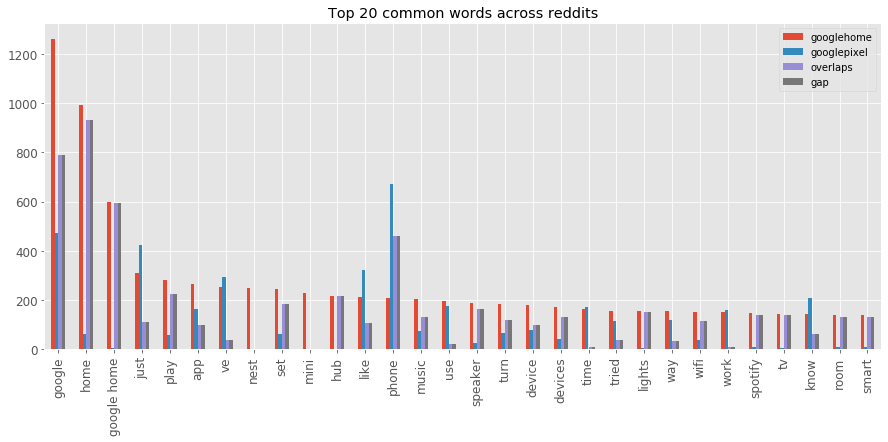

In [144]:
# plot 20 most used words
word_counts.sort_values(['googlehome','googlepixel'], ascending=False).drop('sum', axis=1).head(30).\
plot(kind='bar',figsize=(15,6),fontsize=12,title='Top 20 common words across reddits');

In [33]:
print(f"googlehome total posts: {df_gh1.shape[0]}, word count: {word_counts['googlehome'].sum()}")
print(f"googlepixel total posts: {df_gp1.shape[0]}, word count: {word_counts['googlepixel'].sum()}")

googlehome total posts: 824, word count: 39648.0
googlepixel total posts: 802, word count: 45369.0


While the word `google` is unexpectedly common with 1731 instances, an interestingly observation is that it is not as prevalent for google pixel posts compared to google home. This could be due to consumers referring the google handphone simply as `pixel`. 
For (binary) classification problem, the ideal case is perfect separation in features for the classes. However, this is rarely the case in actual world environment. Observe that there are words that are common between `googlehome` and `googlepixel`. 
We remove words that have two characteristics:
- significant overlaps (smallest difference in word count occurrence in both classes)
- occur frequently. From the plot above, word count occurrence of more than 200 is determined emohirically to be a suitable  measure. 

In [147]:
# find words with 
# 1. significant overlaps
# 2. measure by gap (difference of word count between googlehome & googlepixel class)
# 3. identify the more significant occuring ones by population proportion
word_counts['gap'] = abs(word_counts['googlehome'] - word_counts['googlepixel'])
# sort by most used values
word_counts.sort_values(['gap'], ascending=True).loc[(word_counts['sum']>300) & (word_counts['gap']<50)]

,googlehome,googlepixel,sum,overlaps,gap
work,150.0,158.0,308.0,8.0,8.0
time,164.0,174.0,338.0,10.0,10.0
use,197.0,177.0,374.0,20.0,20.0
ve,254.0,293.0,547.0,39.0,39.0


In [149]:
word_counts.sort_values(['gap'], ascending=True).loc[(word_counts['sum']>200) & (word_counts['gap']<50)]

,googlehome,googlepixel,sum,overlaps,gap
does,138.0,140.0,278.0,2.0,2.0
work,150.0,158.0,308.0,8.0,8.0
time,164.0,174.0,338.0,10.0,10.0
want,139.0,120.0,259.0,19.0,19.0
use,197.0,177.0,374.0,20.0,20.0
using,129.0,162.0,291.0,33.0,33.0
way,155.0,121.0,276.0,34.0,34.0
assistant,138.0,102.0,240.0,36.0,36.0
ve,254.0,293.0,547.0,39.0,39.0
tried,156.0,116.0,272.0,40.0,40.0


The top 10 words commonly overlapping words are [`does`, `work`, `time`, `want`, `use`, `using`, `way`, `assistant`, `ve`, `tried`] are the more common words among the two reddits with significant overlap (similar distribution, with word count aprrox. 200). To measure the impact on model predictive accuracy, it is proposed compare a logreg model without removing these key words and another logreg model with these key words removed.  

### Word Art
---
Following the EDA process, we received a request from the marketing department. They wanted to understand the hot topics for google home and google pixel by inference of the keywords from Reddit posts. While word cloud is technically not data science, we make a small detour to help them out.

In [34]:
# grab libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from matplotlib.pyplot import imread
%matplotlib inline

import numpy as np

In [35]:
# create a list of all the text from googlehome
wa_gh = pd.DataFrame(cvec.fit_transform(googlehome_tdf['selftext']).toarray(), columns=cvec.get_feature_names())
all_textgh = []
for x in wa_gh:
    all_textgh.append(x)

In [36]:
# create a list of all the text from googlepixel
wa_gp = pd.DataFrame(cvec.fit_transform(googlepixel_tdf['selftext']).toarray(), columns=cvec.get_feature_names())
all_textgp = []
for x in wa_gp:
    all_textgp.append(x)

In [37]:
# format it into str
# In Python 3, unicode has been renamed to str.
googlehome_text = str(all_textgh)
googlepixel_text = str(all_textgp)

In [38]:
# Define function to generate wordart (wordcloud)
def cloud(source_text):
    stop_words = ["ve'"] + list(STOPWORDS)
    wordcloud = WordCloud(max_words=200,\
                          stopwords=stop_words,\
                          background_color="black",\
                          min_font_size=10,\
                          colormap='viridis').generate(source_text)
    
    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

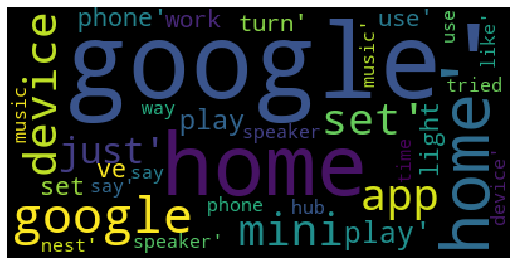

In [39]:
# Generate word cloud image for googlehome
cloud(googlehome_text)

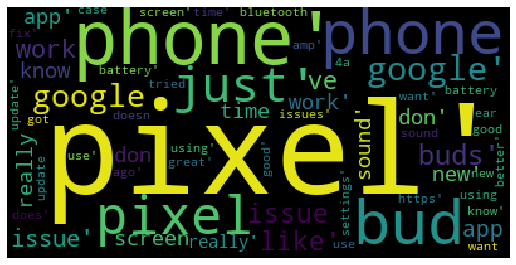

In [40]:
# Generate word cloud image for googlepixel
cloud(googlepixel_text)

### Model Prep
---
First split data into train and test set, then fit only on the train set and transform the test set. This is to prevent data leakage from the test set to the train set (i.e. resultant model will be overfitted and not generalize well to new, unseen data). In other words, excercise caution not to inadvertently countvectorize (a transformer) the data first before doing train-test-split.

In [41]:
# Create train test split
# X is selftext. y is googlehome.
X_train,X_test,y_train,y_test = train_test_split(df[['selftext']],df['googlehome'],test_size=0.25,\
                                                 stratify=df['googlehome'],\
                                                 random_state=42)

In [42]:
# Equal proportion of classes split across train and test set
print(y_train.value_counts())
y_test.value_counts()

1    618
0    601
Name: googlehome, dtype: int64


1    206
0    201
Name: googlehome, dtype: int64

In [240]:
y_test

288     1
1604    0
125     1
273     1
318     1
       ..
106     1
1388    0
697     1
25      1
718     1
Name: googlehome, Length: 407, dtype: int64

In [44]:
# Lines of text in test set and train set
lines_train = X_train.shape[0]
lines_test = X_test.shape[0]
print(f"Lines in train set: {lines_train}.")
print(f"Lines in test set: {lines_test}.")

Lines in train set: 1219.
Lines in test set: 407.


In [45]:
# Instantiate porterstemmer
p_stemmer = PorterStemmer()

In [46]:
# Define function to convert a raw selftext to a string of words
# The input is a single string (a raw selftext), and 
# the output is a single string (a preprocessed selftext)

def selftext_to_words(raw_selftext):
    
    # 1. Remove HTML.
    selftext_text = BeautifulSoup(raw_selftext).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", selftext_text)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stemming of words
    meaningful_words = [p_stemmer.stem(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result
    return(" ".join(meaningful_words))

In [47]:
#Initialize an empty list to hold the clean reviews.
X_train_clean = []
X_test_clean = []

#For train set
# Instantiate counter.
j = 0
for text in X_train['selftext']:
    """Convert text to words, then append to cX_train_clean."""
    X_train_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Clean & parse {j + 1} of {lines_train+lines_test}.')
    
    j += 1

# For test set
for text in X_test['selftext']:
    """Convert text to words, then append to cX_train_clean."""
    X_test_clean.append(selftext_to_words(text))
    
    # If the index is divisible by 1629, print a message.
    if (j + 1) % (lines_train+lines_test) == 0:
        print(f'Clean and parse {j + 1} of {lines_train+lines_test}.')
    
    j += 1

C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/telb95S" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/Wp9EwEn" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\65943\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/obeUnIH" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that

Clean & parse 1000 of 1626.
Clean and parse 1626 of 1626.


### Baseline accuracy
---
We first derive the baseline accuracy so as to be able to determine if the subsequent models are better than the baseline (null) model (predicting the plurality class).

In [48]:
y_test.value_counts(normalize=True)

1    0.506143
0    0.493857
Name: googlehome, dtype: float64

The Baseline accuracy is the percentage of the majority class. In this case, the baseline accuracy is 0.506143. 
This serves as benchmark for measuring model performance (i.e. model accuracy should be higher than this baseline).

### Logistic Regression Model
---

In [49]:
# Set up a pipeline with two stages
# 1.CountVectorizer (transformer)
# 2.LogisticRegression (estimator)
pipe = Pipeline([('cvec',CountVectorizer()),\
                 ('logreg',LogisticRegression(solver='lbfgs',max_iter=200,random_state=42))\
                ])

In [50]:
# Parameters of pipeline object
pipe.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='cont

In [51]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [52]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs = GridSearchCV(pipe,\
                  param_grid=pipe_params,\
                  cv=5)

In [53]:
# Fit GridSearch to the cleaned training data.
gs.fit(X_train_clean,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [54]:
# Check the results of the grid search
# Note the Score is against one-fifth (hold-out set) of train data
print(f"Best parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9278115091411994


In [55]:
# Save best model as gs_model.
# Trained on four-fifth of data.
gs_model = gs.best_estimator_

In [56]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs_model.score(X_train_clean, y_train)}")
print(f"Accuracy on test set: {gs_model.score(X_test_clean, y_test)}")

Accuracy on train set: 0.9983593109105825
Accuracy on test set: 0.9213759213759214


The model accuracy is higher than the baseline accuracy (0.506). However, the model is overfitted with 7% drop in test accuracy compared to train accuracy. 

In [69]:
# Confusion matrix on the first log reg model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds = gs.predict(X_test_clean)
cm = confusion_matrix(y_test, preds)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,183,18
Actual googlehome,14,192


The positive class (class 1) refers to `googlehome`. False positive means the observation is classified as `googlehome` when it is actually `googlepixel`. 
False negative means the ovservation is classified as `googlepixel` when it is actually `googlehome`.

In [75]:
# return nparray as a 1-D array.
confusion_matrix(y_test, preds).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()

In [76]:
# Summary of metrics for first log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs.score(X_test_clean,y_test),4)}")

Specificity: 0.9104
Sensitivity: 0.932
Accuracy: 0.9214


The Receiver Operating Characteristic curve is a way to visualize the overlap between our positive class and negative class by moving our classification threshold from 0 to 1. The more area under the blue curve, the better separated the class distributions are.

In [78]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs.predict_proba(X_test_clean)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
288,1,0.984141
1604,0,0.000077
125,1,0.998117
273,1,0.999981
318,1,0.946775


In [79]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

In [80]:
# Calculate ROC AUC.
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.9825146114089747

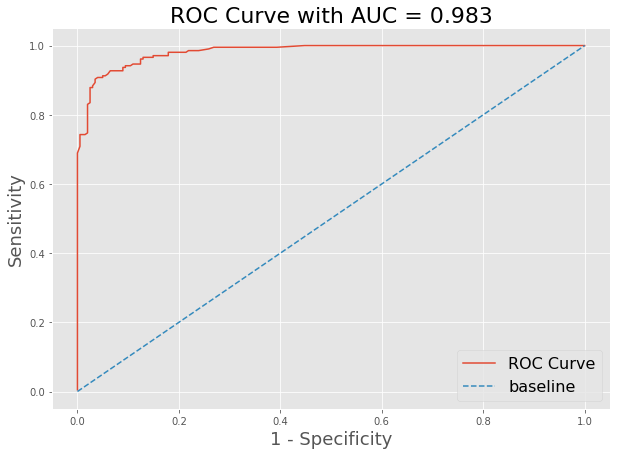

In [81]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

An ROC AUC of 1 means the positive and negative populations are perfectly separated and that the model is as good as it can get. The closer the ROC AUC is to 1, the better. (1 is the maximum score.)

What would be the impact on model accuracy with the removal of the discovered overlapping key words? Let's find out.

In [151]:
# Set up a pipeline, pipe2 with two stages
# 1.CountVectorizer (transformer)
# 2.LogisticRegression (estimator)
# 3.Remove the words ['does', 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried'] 
# via CountVectorizer
pipe2 = Pipeline([('cvec',CountVectorizer(stop_words=['does', 'work', 'time', 'want', 'use',\
                                                      'using', 'way', 'assistant', 've', 'tried'])),\
                  ('logreg',LogisticRegression(solver='lbfgs',max_iter=200,random_state=42))\
                 ])

In [152]:
# Parameters of pipeline object
pipe2.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None,
                   stop_words=['does', 'work', 'time', 'want', 'use', 'using',
                               'way', 'assistant', 've', 'tried'],
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=200,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec': CountVectorizer(

In [153]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe2_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [154]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs2 = GridSearchCV(pipe2,\
                  param_grid=pipe2_params,\
                  cv=5)

In [155]:
# Fit GridSearch to the cleaned training data.
gs2.fit(X_train_clean,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [156]:
# Check the results of the grid search
# Note the Score is against one-fifth (hold-out set) of train data
print(f"Best parameters: {gs2.best_params_}")
print(f"Best score: {gs2.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
Best score: 0.9294508534034946


In [157]:
# Save best model as gs_model.
# Trained on four-fifth of data.
gs2_model = gs2.best_estimator_

In [158]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs2_model.score(X_train_clean, y_train)}")
print(f"Accuracy on test set: {gs2_model.score(X_test_clean, y_test)}")

Accuracy on train set: 0.9983593109105825
Accuracy on test set: 0.914004914004914


### ??check w TA Thurs or Fri
The removal of the identified key words has little impact on improving test accuracy score. It would appear that the first logreg model would still be better in terms of prediction accuracy.

In [164]:
# Confusion matrix on the second log reg model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds2 = gs2.predict(X_test_clean)
cm = confusion_matrix(y_test, preds2)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,183,18
Actual googlehome,17,189


Not surprisingly, the number of False positive/ False negatives increased with the slight decreased in test accuracy, compared to the first log reg model. 

In [188]:
# return nparray as a 1-D array.
confusion_matrix(y_test, preds2).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test,preds2).ravel()

In [189]:
# Summary of metrics for first log reg model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs2.score(X_test_clean,y_test),4)}")

Specificity: 0.9104
Sensitivity: 0.9175
Accuracy: 0.914


In [167]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs2.predict_proba(X_test_clean)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
288,1,0.982440
1604,0,0.000116
125,1,0.998975
273,1,0.999964
318,1,0.958908


In [168]:
# Calculate ROC AUC.
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.98319084190697

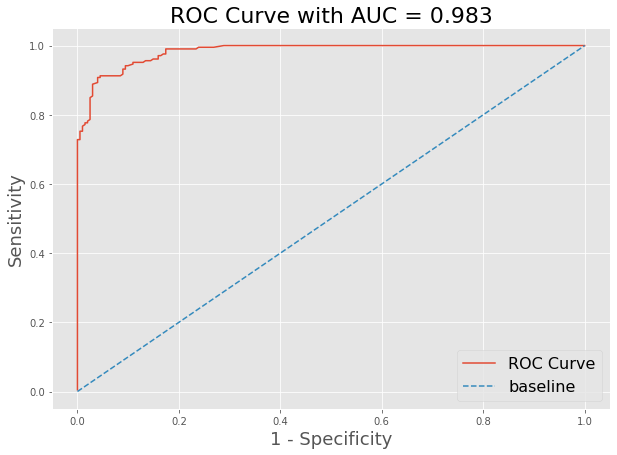

In [169]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed orange line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

We see that effect in removal of the identified common overlapping words is minimal.

### Naive Bayes Model
---

In [177]:
# Set up a pipeline, p3 with two stages
# 1.CountVectorizer (transformer)
# 2.Naive Bayes(multinomial) (estimator)
pipe3 = Pipeline([('cvec',CountVectorizer()),\
                 ('nb',MultinomialNB())\
                ])

In [178]:
# Parameters of pipeline object
pipe3.get_params()

{'memory': None,
 'steps': [('cvec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'cvec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 'nb': M

In [179]:
# Load pipeline object into GridSearchCV to tune CountVectorizer
# Search over the following values of hyperparameters:
# Maximum number of features fit (top no. frequent occur words): 2000, 3000, 4000, 5000
# Minimum number of documents (collection of text) needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

# n-gram: 1 token, 1-gram, or 1 token, 2-gram.
pipe_params = {
    'cvec__max_features': [2_000,3_000,4_000,5_000],\
    'cvec__min_df': [2,3],\
    'cvec__max_df': [0.9,0.95],\
    'cvec__ngram_range': [(1, 1), (1,2)]\
}

In [180]:
# Instantiate GridSearchCV.
"""pipe refers to the object to optimize."""
"""param_grid refer to parameter values to search."""
"""cv refers to number of cross-validate fold."""
gs3 = GridSearchCV(pipe,\
                  param_grid=pipe_params,\
                  cv=5)

In [181]:
# Fit GridSearch to the cleaned training data.
gs3.fit(X_train_clean,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [201]:
# Check the results of the grid search
# Note the Score is against one-fifth (hold-out set) of train data
print(f"Best parameters: {gs3.best_params_}")
print(f"Best score: {gs3.best_score_}")

Best parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Best score: 0.9466808338393037


In [202]:
# Save best model as gs_model.
# Trained on four-fifth of data.
gs_model = gs3.best_estimator_

In [203]:
# Score model on training set & testing set
print(f"Accuracy on train set: {gs_model.score(X_train_clean, y_train)}")
print(f"Accuracy on test set: {gs_model.score(X_test_clean, y_test)}")

Accuracy on train set: 0.9639048400328137
Accuracy on test set: 0.9656019656019657


The naive bayes test accuracy is higher than the train accuracy, so the model doesn't appear to be overfitted on the training data.
Compared to the logistic regression models, naive bayes model has:
- lower accuracy on train set
- higher accuracy on test set.

The naive bayes model performs better than the logistic regression model.

In [268]:
# Confusion matrix on the first naive bayes model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is googlehome
preds3 = gs3.predict(X_test_clean)
cm = confusion_matrix(y_test, preds3)
cm_df = pd.DataFrame(cm,columns=['pred googlepixel','pred googlehome'], index=['Actual googlepixel','Actual googlehome'])
cm_df

,pred googlepixel,pred googlehome
Actual googlepixel,193,8
Actual googlehome,6,200


With a higher test accuracy, there is a lower number of False positive/ False negatives in test prediction. Almost equal number of false positives and false negatives.

In [192]:
# return nparray as a 1-D array.
confusion_matrix(y_test, preds3).ravel()
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test,preds3).ravel()

In [207]:
# Summary of metrics for first naive bayes model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")
print(f"Accuracy: {round(gs3.score(X_test_clean,y_test),4)}")

Specificity: 0.9602
Sensitivity: 0.9709
Accuracy: 0.9656


In [208]:
# To visualize the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs3.predict_proba(X_test_clean)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
288,1,1.000000e+00
1604,0,2.665073e-18
125,1,1.000000e+00
273,1,1.000000e+00
318,1,1.000000e+00


In [209]:
# Calculate ROC AUC.
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.9892286142105009

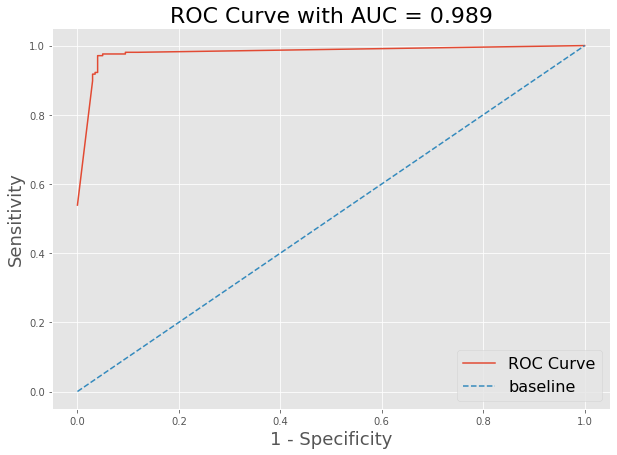

In [210]:
#Create figure
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed blue line in plot.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## ? Check w TA how does one go about describing the ROC curve??

### Model Performance Summary and Review of Production Model
---

In [339]:
from sklearn.metrics import classification_report

In [361]:
# Define function to print model performance metrics and roc auc
def scores(model):
    print(classification_report(y_test, model.predict(X_test_clean)))
    pred_proba = [i[1] for i in model.predict_proba(X_test_clean)]
    print(f"roc_auc: {round(roc_auc_score(pred_df['true_values'],pred_df['pred_probs']),3)}")

In [362]:
# Summary scores for Logistic Regression Model
scores(gs)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       201
           1       0.96      0.97      0.97       206

    accuracy                           0.97       407
   macro avg       0.97      0.97      0.97       407
weighted avg       0.97      0.97      0.97       407

roc_auc: 0.989


In [363]:
# Summary scores for Logistic Regression Model (words removed)
# List of words removed
# ['does' 'work', 'time', 'want', 'use', 'using', 'way', 'assistant', 've', 'tried']
scores(gs2)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       201
           1       0.91      0.92      0.92       206

    accuracy                           0.91       407
   macro avg       0.91      0.91      0.91       407
weighted avg       0.91      0.91      0.91       407

roc_auc: 0.989


In [364]:
# Summary scores for Naive Bayes model
scores(gs3)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       201
           1       0.96      0.97      0.97       206

    accuracy                           0.97       407
   macro avg       0.97      0.97      0.97       407
weighted avg       0.97      0.97      0.97       407

roc_auc: 0.989


Deeper Look at Classifications of the Naive Bayes Model 
---
For the test accuracy and roc_auc scores, the Naive Bayes is selected as the better performing model. This section examines the features that
- helps with negative (googlepixel) and positive (googlehome) classifications,
- what could be the features that lead to misclassifications.

In [365]:
# Review model coefficients to see which word is helping with negative / positive classifications)
# As GridSearchCV' object has no attribute 'feature_log_prob_,
# Build separate naive bayes model to enable model coefficient extraction
# using best parameters discovered above in gs3

# Instantiate our CountVectorizer
cv = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=3,max_features=3000)

# Fit and transform training data
X_train_cleancv = cv.fit_transform(X_train_clean)

# Transform test data
X_test_cleancv = cv.transform(X_test_clean)

In [366]:
# Instantiate model
nb = MultinomialNB()

# Fit model
model = nb.fit(X_train_cleancv,y_train)

# Generate predictions
predictions = nb.predict(X_test_cleancv)

In [367]:
import numpy as np
#prob for positive class
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
#prob for negative class
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
#getting the top features 
pos_top_features = np.take(cvec.get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(cvec.get_feature_names(), neg_class_prob_sorted)


In [375]:
# List of top 30 words that helps in 'googlehome' (positive) classification
print(pos_top_features[:30])

['frustrating' 'friend told' 'friendly' 'friends' 'frustrated'
 'buds haven' 'fucking' 'fully' 'freeze' 'apologies' 'functional'
 'galaxy a51' 'going' 'going completely' 'good 30' 'good place'
 'google play' 'fun' 'google translate' 'freaking amazing' 'app problem'
 'appreciated cheers' 'appreciated' 'appreciate' 'apply' 'applied'
 'apple just' 'apple com' 'app play' 'apple']


In [379]:
# List of top 30 words that helps in 'googlepixel' (negative) classification
print(neg_top_features[:30])

['discrepancy' 'html' 'launching' 'makes' 'hard time' 'leaning'
 'hours sot' 'dumb' 'hardware design' 'hour' 'dr good' 'hot' 'hospital'
 'horrible battery' 'horrible' 'bad batch' 'fix ve' 'guessing' 'avrcp'
 'clock app' 'controls pixel' 'controls' 'maybe' 'ear phone' 'grain salt'
 'different phone' 'ear long' 'ear left' 'great audiophile'
 'great battery']


Surprisingly, the top 20 words that aided in postive/ negative classifications are neither `google home` nor `google pixel`. 

**Googlehome**: For positive class (googlehome), it could be inferred that the users reviews seems quite balanced. The word `apple` surfaced, possibly as a mention as comparison of `apple` product performance-related topics with google's. Further analysis could be done into contents with word of negative conotation such as `frustrating`, `frustrated`, `fucking` to better understand the technical issues causing users' frustrations. The main issues with IoT devices are interoperability and connectivity, but it remains to be seen if this is the case for the current google home reddit text analysis.

**Googlepixel**: For negative class (googlepixel), there are more words (eight) with negative conotations, from `horrible battery` to `dumb` and `bad batch`. Typical smartphone issues range from dismal battery life to poor build quality and these words seem to reinforce this view. The google R&D and production lines would do well to learn from these negative user reviews.

**Reviewing the misclassified samples**: What could be the features that lead to misclassifications?

In [380]:
# Pass y_test (pandas series) into dataframe first
# in order to use the original selftext indexes for traceability
actual = pd.Series(y_test)
df_rvw = actual.to_frame()

# Create column of predicted classes from Naive Bayes model
df_rvw['pred'] = preds3
# Include the selftext data
df_rvw['selftext'] = X_test_clean

# Review the dataframe
df_rvw.head()

,googlehome,pred,selftext
288,1,1,doe anyon know how to turn off the featur that...
1604,0,0,hey y all after sell my pixel xl for more than...
125,1,1,hi i ve just recent bought a nest home mini an...
273,1,1,when we go to bed we ask the googl home mini t...
318,1,1,i ve set up an album on googl photo and my nes...


In [394]:
# Index of misclassified classes
row_ids = df_rvw[df_review9['googlehome'] != df_rvw['pred']].index
row_ids

Int64Index([603, 1498, 1215, 525, 469, 276, 749, 1571, 888, 117, 864, 1316,
            1024, 922],
           dtype='int64')

In [328]:
# Create overview of the misclassified 
for i in row_ids:
    print(df_rvw.loc[i])

googlehome                                                    1
pred                                                          0
selftext      as someon who ha a lot of kit and who know hi ...
Name: 603, dtype: object
googlehome                                                    0
pred                                                          1
selftext      how is it possibl googl advertis a stabl bluet...
Name: 1498, dtype: object
googlehome                                                    0
pred                                                          1
selftext      hi i m on my phone a pixel and whenev i m ask ...
Name: 1215, dtype: object
googlehome                                                    1
pred                                                          0
selftext      anyon have similar issu sinc lastest updat and...
Name: 525, dtype: object
googlehome                                            1
pred                                                  0
selftext      view

Two samples from each of misclassified samples are examined in further detail in this section.

**False Negative**: Predicted as googlepixel post but is actually googlehome post. Potential reason could be due to the presence of words such as `phone` and `updat` that are more common in the context of smartphones.

In [393]:
# Example 1 of false negative classification
print(df_rvw['selftext'][603])

as someon who ha a lot of kit and who know hi way around hi devic and a phone i find the whole experi to be veri pain the question they ask are probabl script and i don t necessarili have a solut to the problem i just wish there wa a process that more savvi user could follow to say ye i ve uninstal and reinstal the app no there are no updat ye i ve restart my devic no but i ve tri throw it out the window argh anyway just a littl rant


In [392]:
# Example 2 of false negative classification
print(df_rvw['selftext'][525])

anyon have similar issu sinc lastest updat and or have a fix plug have been work smoothli until thi last round of updat


**False Positive**: Predicted as googlehome post but is actually googlepixel post. Potential reason could be due to the presence of words that are related to phone and phone calls (google home can make home calls) that lead to misclassification as pixel (smartphone) post.

In [395]:
# Example 1 of false positive classification
print(df_rvw['selftext'][1498])

how is it possibl googl advertis a stabl bluetooth connect through multipl wall of a hous or yard outsid and it can t keep a stabl connect feet away through nike gym short crazi


In [399]:
# Example 2 of false positive classification
print(df_rvw['selftext'][1024])

i have a group text that i chang the group name but it say it will onli show on my phone i have been unabl to find a way to have it show on everybodi s phone i am use the default android messeng doe anybodi know if thi is possibl


### Recommendations and Way Forward

Model good to go. Further enhancements could be implemented in version 2. What more can be done is to switch to review rival product posts for more insights.